#### Q1: Simulation 
Simulate Bid-ask spread dynamics for the following question: 
* The end-of-day value of a share of stock, V, is random
* At market close: either $V_H$=150 or $V_L$=100
    * With equal probability
* Before trading starts, the expected value is
    * EV=$\frac{1}{2}150 + \frac{1}{2} 100$=125
    * This is the unconditional expected value
* There are two types of traders
    * Informed traders know V
    * Uninformed (``retail'') traders don't know V
* The dealer doesn't know V
* Uninformed traders are equally likely to buy or sell
* Informed traders observe V and decide the optimal trading strategy 
* After the dealer sets the bid and ask quote, a trader arrives. 
    * Assuming: Prob(uninformed) = 0.8 and Prob(informed) = 0.2


Plot Bid-ask spread dynamics for the following two scenarios (b is buy order and s is sell order)
1) s,s,b,s,s,b,s,s,s,s,s,s
2) s,b,b,s,b,b,s,b,b,b,b,b


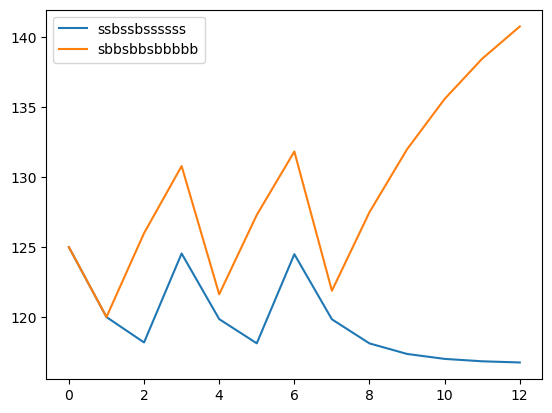

In [452]:
import matplotlib.pyplot as plt
pi = 0.2 # Prob(informed)
theta = 0.5 # probability that market close at VH
V_H = 150
V_L = 100

def price(signal,theta):
    if signal == 'b':
        theta += theta*(1-theta)*pi/((1-pi)*theta+pi*theta)
        return (theta, theta * V_H + (1-theta) * V_L)
    elif signal == 's':
        theta = theta*(1-pi)/2/((1-pi)*theta+pi*(1-theta))
        return (theta, theta * V_H + (1-theta) * V_L)
        
signals = ['ssbssbssssss','sbbsbbsbbbbb']
EV_t_list = [[],[]]
for i in range(2):
    theta = 0.5
    EV = theta * V_H + (1-theta) * V_L
    EV_t_list[i].append(EV)
    for j in signals[i]:
        theta,EV_t = price(j,theta)
        EV_t_list[i].append(EV_t)
for i in range(2):
    plt.plot(EV_t_list[i],label=signals[i])
plt.legend()

#### Q2: Data cleanning and data analysis 
This exercise is about ﬁxed income markets. Corporate bonds are largely traded in OTC markets. Academic Corporate Bond TRACE Dataset contains historic transaction-level data on all eligible corporate bondsinvestment grade, high yield and convertible debt. We use this dataset to understand the bond market during the COVID-19 Crisis.

* bond.csv.zip is the dataset containing TRACE data downloaded from WRDS
* VariableList.csv contains the variable description, and more detailed description is in TRACE Variable.pdf
* I will not give you instructions to clean the data. You need to underrstand what variables to use and decide your way to handle the data 

##### Data Cleaning 
* How many different companies and corporate bonds are in the data set?

* Plot the histogram of the number of trading days 

* The data reports the contra-party type. 
    * Calculate spread for each trade as follows. Note that we do not see bid/ask prices at OTC markets, so the calculation of spread is not direct. We follow the calculation in
    $$spread = 2Q * \frac{traded price - reference price}{referenc price}$$
    where Q is +1 for a customer buy and −1 for a customer sell. For each trade, we calculate its reference price as the volume-weighted average price of trades in the same bond-day
    * Plot the histogram of calculated trade spread. Do you notice that 1) lots of spreads are exactly zero, 2) there are entries with very large spreads? Please answer why those spreads are zero? Give one example to explain outlier spreads (check news and list one example that may lead to large spreads)

#### Import the relevant modules

In [301]:
### In this project, I will use datatable (quicker) rather pandas to manipulate data. You can see which one is more intuitive for you 
from datetime import datetime
import datatable as dt
from datatable import dt, f, by, update
from regpyhdfe import Regpyhdfe
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd
bond = pd.read_csv('/Users/yiyujie/Desktop/program/Trading, Market Frictions, and FinTech/TRACE/bond.csv')
bond['trd_exctn_dt'] = pd.to_datetime(pd.to_datetime(bond.trd_exctn_dt,format="%Y%M%d").dt.date)
bond['trd_exctn_tm'] = pd.to_datetime(bond['trd_exctn_tm'], format='%H:%M:%S').dt.floor('T').dt.time.astype('str')
bond['ascii_rptd_vol_tx'] = pd.to_numeric(bond['ascii_rptd_vol_tx'], errors='coerce')
bond = bond.sort_values(by=['trd_exctn_dt','trd_exctn_tm'])

In [223]:
# count the number of different companies and bonds
print(bond['company_symbol'].value_counts())
print(bond['bond_sym_id'].value_counts())
# count the number of each company's bonds
bond.groupby('company_symbol')['bond_sym_id'].apply(lambda x: len(x.unique()))

company_symbol
AAPL    172019
AMZN     56261
TSLA     22124
AAL      17651
AMC       7610
Name: count, dtype: int64
bond_sym_id
AAPL4001809    16064
AAPL4336441    12338
TSLA4530907    11302
AAPL4122392     9966
AAPL4122390     6805
               ...  
TSLA4265473        2
TSLA4231716        2
TSLA4230053        2
AMC5128458         1
AMC5076724         1
Name: count, Length: 156, dtype: int64


company_symbol
AAL     46
AAPL    59
AMC      8
AMZN    21
TSLA    22
Name: bond_sym_id, dtype: int64

Text(0, 0.5, 'Frequency')

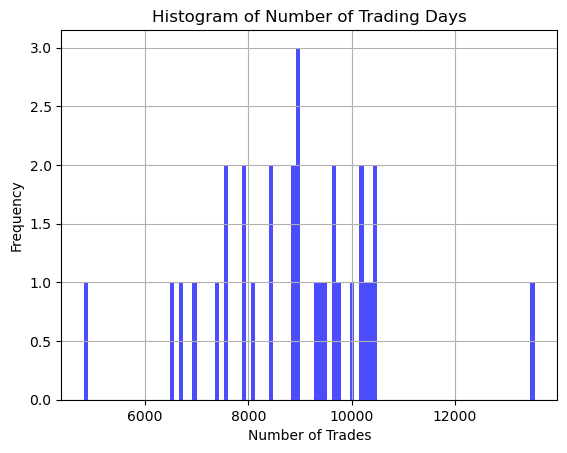

In [224]:
# Plot the histogram of the number of trading days 
bond.trd_exctn_dt.value_counts().hist(bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Number of Trading Days')
plt.xlabel('Number of Trades')
plt.ylabel('Frequency')

In [302]:
weighted_price = bond.groupby(['bond_sym_id', 'trd_exctn_dt']).apply(lambda x: (x['rptd_pr']*x['ascii_rptd_vol_tx']).sum() / x['ascii_rptd_vol_tx'].sum()).reset_index()
weighted_price.columns = ['bond_sym_id', 'trd_exctn_dt', 'weighted_price']
bond = bond.merge(weighted_price, on=['bond_sym_id', 'trd_exctn_dt'], how='left')
bond['Q'] = bond['side'].apply(lambda x: 1 if x == 'B' else -1)
bond['spread'] = 2 * bond['Q'] * (bond['rptd_pr'] - bond['weighted_price']) / bond['weighted_price']

Text(0, 0.5, 'Frequency')

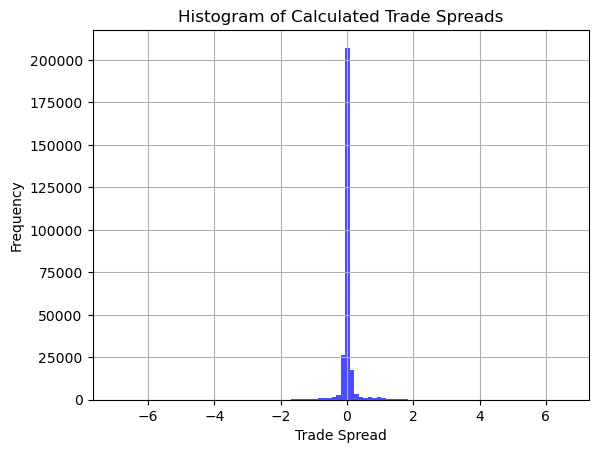

In [226]:
bond['spread'].hist(bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Calculated Trade Spreads')
plt.xlabel('Trade Spread')
plt.ylabel('Frequency')

* Some of the spreads are exactly zero which indicate a very consistent valuation of the bond by both buyers and sellers.
* Some of the spreads are very large. The reason of that may be that some major news releases and bond prices fluctuate significantly. For instance, the global outbreak of COVID-19 in early 2020 created widespread market uncertainty and volatility and many companies' bond prices experienced significant fluctuations, resulting in large spreads

##### Analysis
* Daily analysis 
    * Spread
        * Aggregate spread information to the company-day level. What is the reasonable way in your opinions to do this? 
        * Using bond-day level spreads to calculate the average spread for each stock and present the results. What can we learn from the ranking of the spreads?
        * Plot time-series spread using company-day level data for each company. What patterns do you see, and why is that?
    * Volume 
        * Calculate company-day trading volume for each company
        * Plot histogram of the company-day trading volume. What is the distribution? 
    * Analsyis
        * Does past trading volume predicts future spreads? 
        * Are daily trading volume time-series correlated? 


* Intraday analysis 
    * Spread
        * For each company, construct and plot the intraday spread pattern by minutes 
    * Volume 
        * For each company, construct and plot the intraday volume pattern by minutes 
    * Analysis 
        * Does the interday pattern change during market stress periods? 
        * Is intraday volume predictable? (Note that you can also construct interday return information)

### Daily analysis - Spread

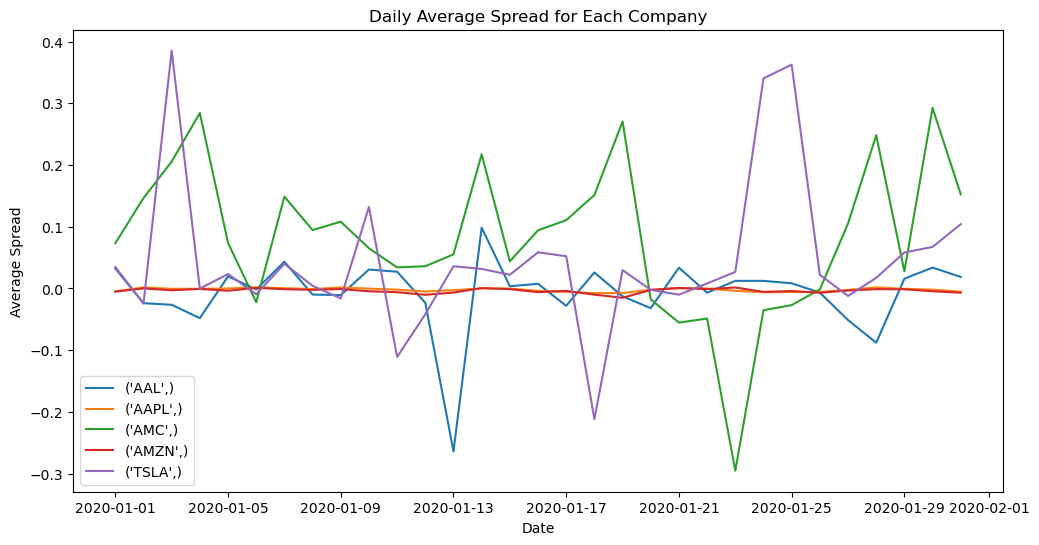

In [303]:
# Daily analysis - Spread
plt.figure(figsize=(12, 6))
for data in bond.groupby(['company_symbol']):
    data_m = data[1].groupby('trd_exctn_dt')['spread'].mean().reset_index()
    plt.plot(data_m['trd_exctn_dt'],data_m['spread'],label=data[0])
plt.title('Daily Average Spread for Each Company')
plt.xlabel('Date')
plt.ylabel('Average Spread')
plt.legend()

* We can see that the AMC and TSLA have big spread and AAPL and AMZN have very small spread.

In [231]:
print(bond.groupby(['bond_sym_id','trd_exctn_dt'])['spread'].mean().sort_values(ascending=False)[:5])
print(bond.groupby(['bond_sym_id','trd_exctn_dt'])['spread'].mean().sort_values(ascending=True)[:5])

bond_sym_id  trd_exctn_dt
TSLA4474416  2020-01-03      1.202656
AMC5040765   2020-01-09      0.933890
TSLA4474416  2020-01-24      0.684129
             2020-01-25      0.612223
AMC4506547   2020-01-16      0.558022
Name: spread, dtype: float64
bond_sym_id  trd_exctn_dt
AMC4506547   2020-01-22     -0.656265
AMC4267538   2020-01-23     -0.639989
AAL4835664   2020-01-13     -0.583634
TSLA4474416  2020-01-18     -0.550915
             2020-01-11     -0.529970
Name: spread, dtype: float64


* For the bond-day level, we can see above that the big spread are mostly from AMC and then from TSLA, AAL company.

### Daily analysis - volume analysis

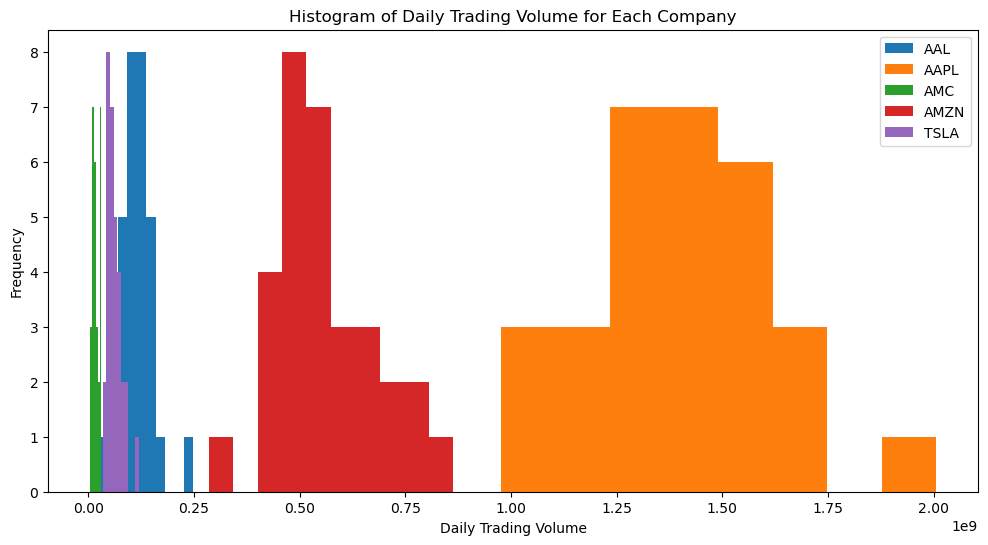

In [352]:
# Daily analysis - volume analysis
plt.figure(figsize=(12, 6))
for data in bond.groupby(['company_symbol']):
    data_m = data[1].groupby('trd_exctn_dt')['ascii_rptd_vol_tx'].sum().reset_index()
    plt.hist(data_m['ascii_rptd_vol_tx'],label=data[0])
plt.title('Histogram of Daily Trading Volume for Each Company')
plt.xlabel('Daily Trading Volume')
plt.ylabel('Frequency')
plt.legend()

* Transaction volumes in ascending  order are AMC, TSLA, AAL, AMZN, AAPL. And we can see that this is the daily spread average in descending order which may indicates that they are negative correlated.

### Daily analysis - Analsyis

In [372]:
print("company   corr between spread and volume")
for data in bond.groupby(['company_symbol']):
    print(data[0],data[1]['spread'].corr(data[1]['ascii_rptd_vol_tx']))

company   corr between spread and volume
('AAL',) 0.008772660857046142
('AAPL',) 0.0026268891206982048
('AMC',) -0.051641714880658364
('AMZN',) 0.007116342481394574
('TSLA',) -0.006211277935412818


The correlation is realy week.

### Intraday analysis - Spread

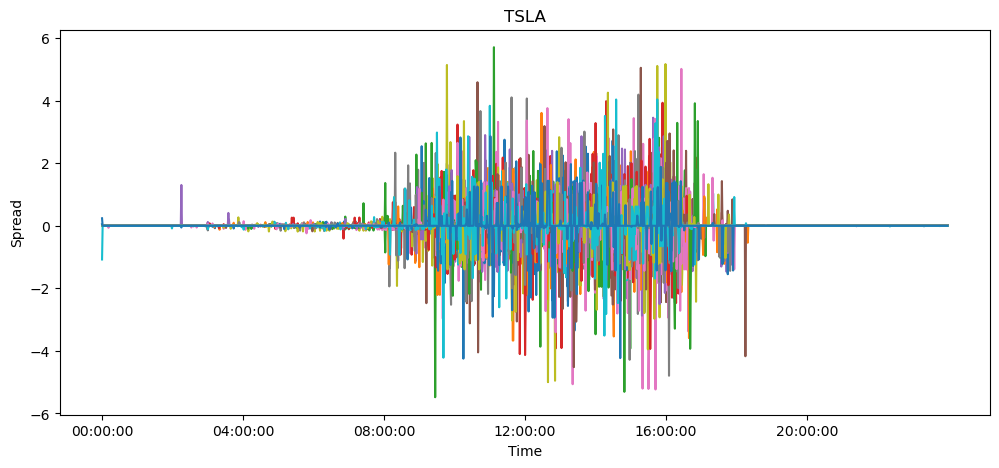

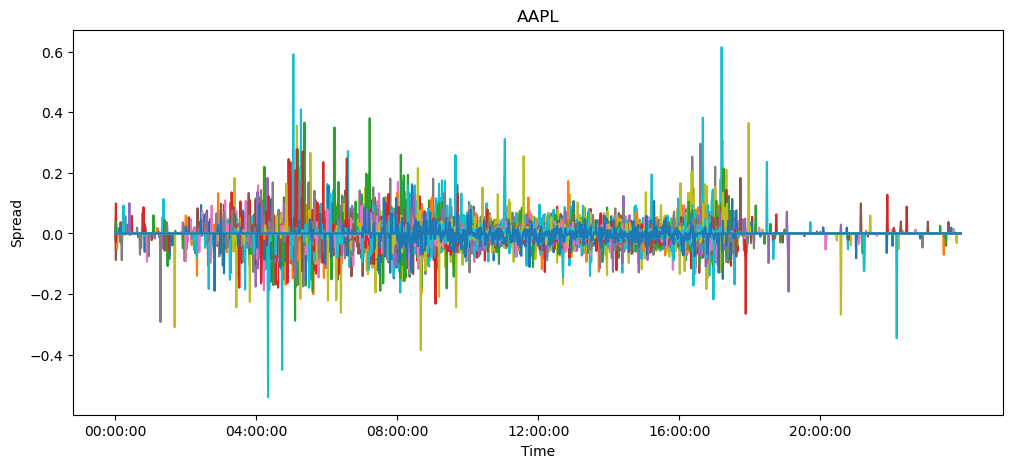

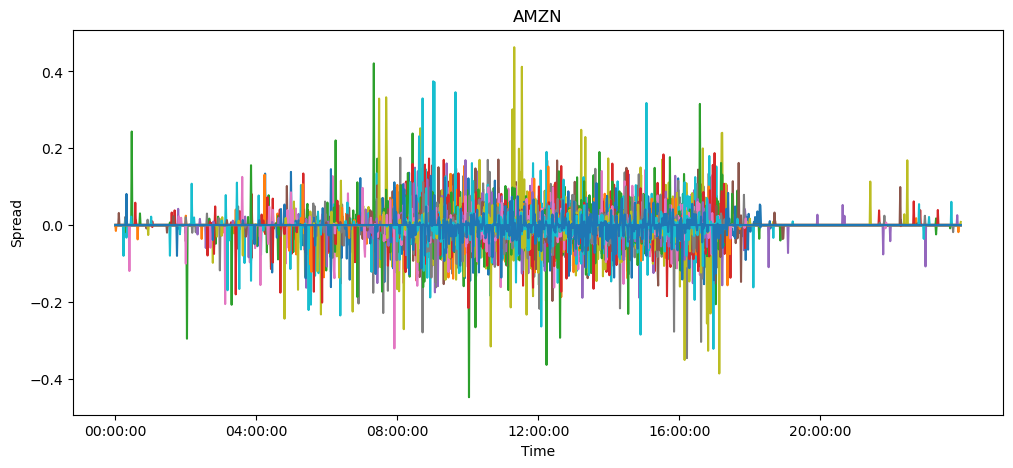

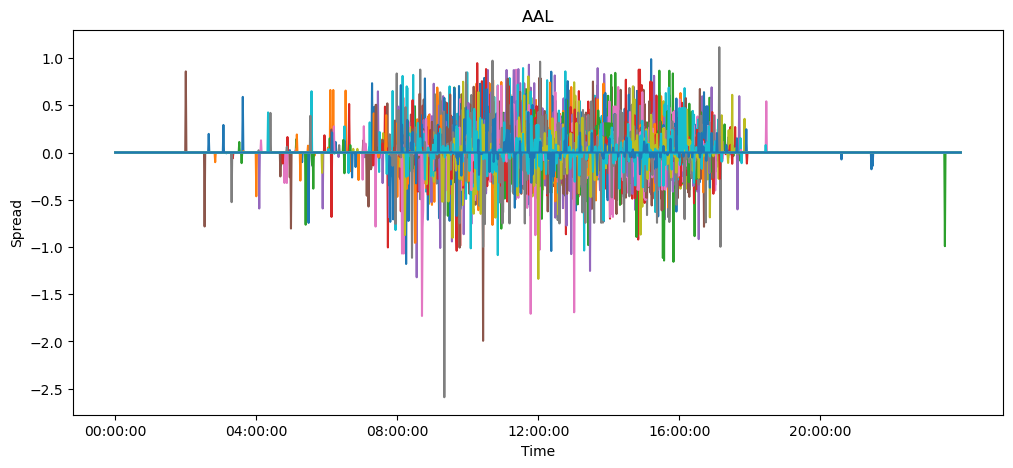

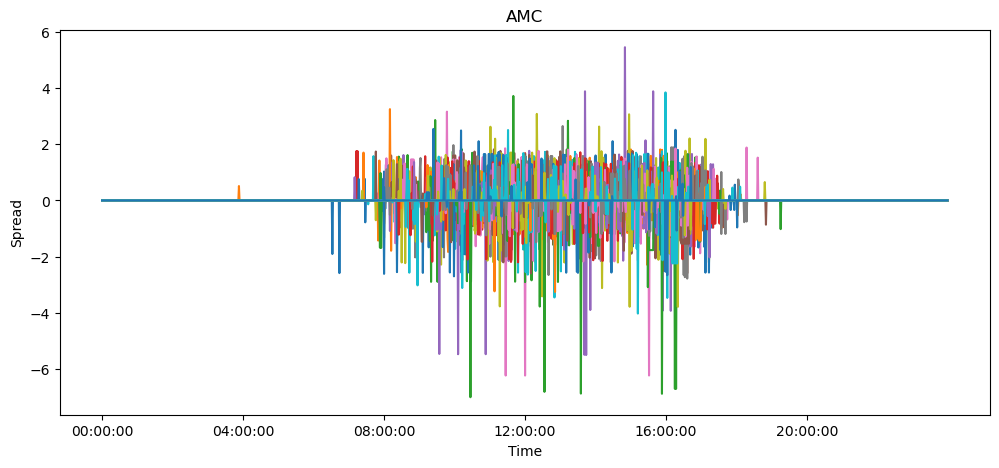

In [348]:
# Intraday analysis - Spread
all_minutes = pd.date_range(start='00:00:00', end='23:59:00', freq='T').strftime('%H:%M:%S')
for company in bond['company_symbol'].unique():
    plt.figure(figsize=(12, 5))
    for day in bond[bond['company_symbol']==company]['trd_exctn_dt'].unique():
        data = bond[(bond['company_symbol']==company)&(bond['trd_exctn_dt']==day)].groupby(['trd_exctn_tm'])['spread'].mean().reset_index().sort_values(by='trd_exctn_tm')
        data = data.set_index('trd_exctn_tm').reindex(all_minutes,fill_value=0).fillna(0).reset_index()
        plt.plot(data['index'], data['spread'], label=day)
    plt.title(company)
    plt.xticks(data['index'][::240].index, data['index'][::240])
    plt.title(company)
    plt.xlabel('Time')
    plt.ylabel('Spread')

### Intraday analysis - Volume

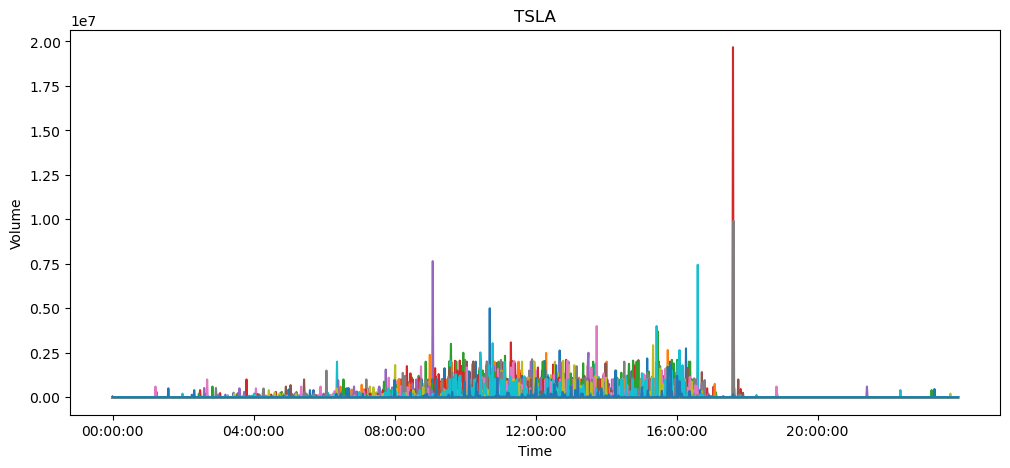

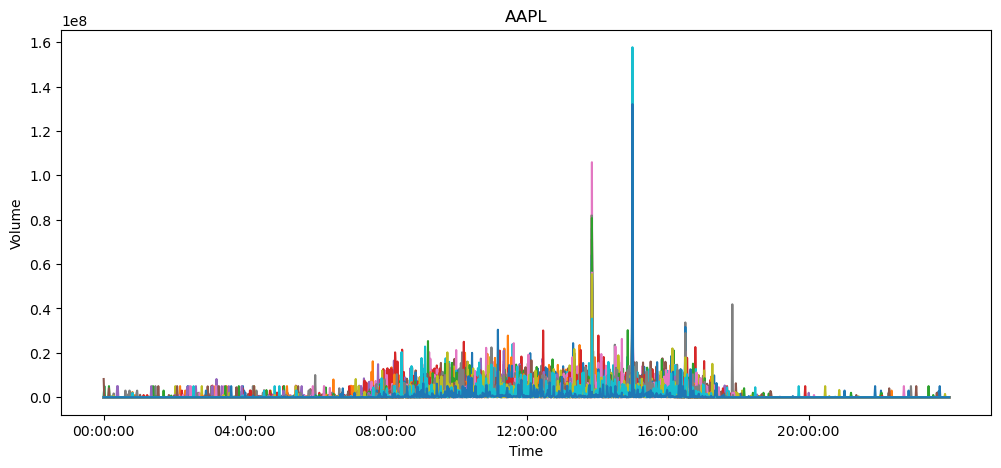

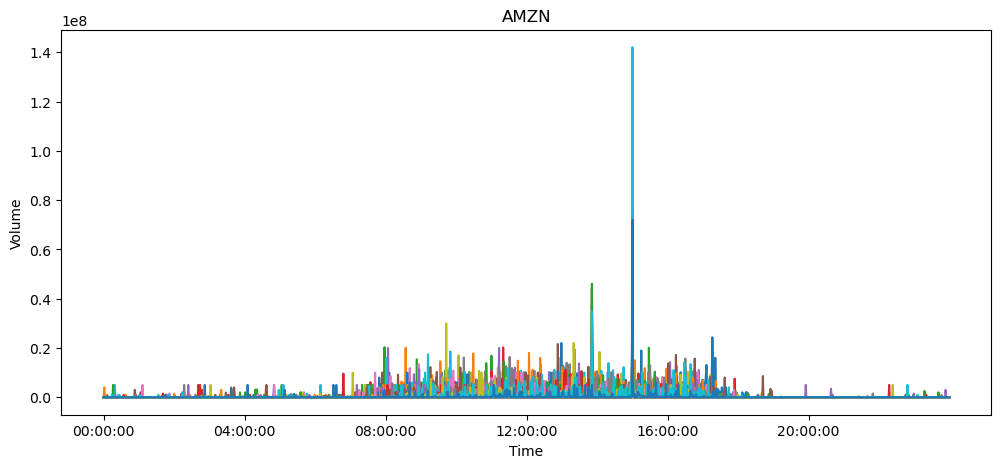

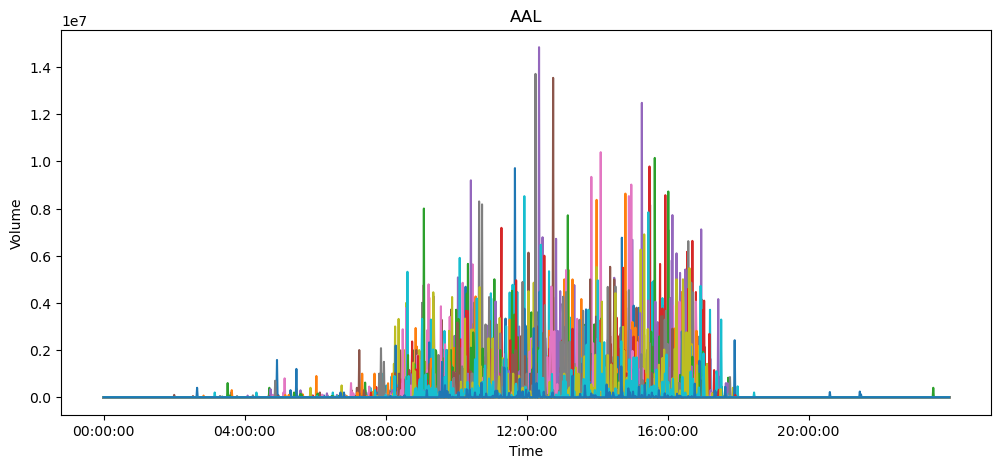

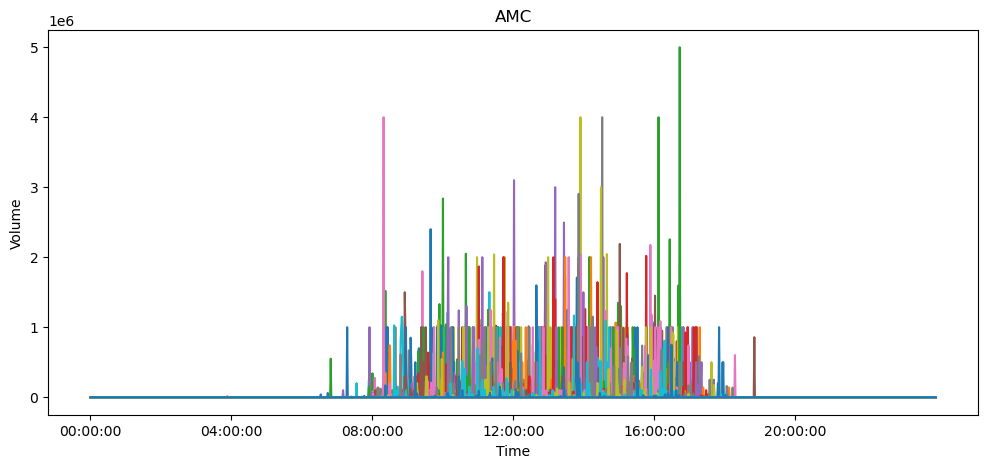

In [347]:
# Intraday analysis - Volume
all_minutes = pd.date_range(start='00:00:00', end='23:59:00', freq='T').strftime('%H:%M:%S')
for company in bond['company_symbol'].unique():
    plt.figure(figsize=(12, 5))
    for day in bond[bond['company_symbol']==company]['trd_exctn_dt'].unique():
        data = bond[(bond['company_symbol']==company)&(bond['trd_exctn_dt']==day)].groupby(['trd_exctn_tm'])['ascii_rptd_vol_tx'].sum().reset_index().sort_values(by='trd_exctn_tm')
        data = data.set_index('trd_exctn_tm').reindex(all_minutes,fill_value=0).fillna(0).reset_index()
        plt.plot(data['index'], data['ascii_rptd_vol_tx'], label=day)
    plt.xticks(data['index'][::240].index, data['index'][::240])
    plt.title(company)
    plt.xlabel('Time')
    plt.ylabel('Volume')

### Intraday analysis - Analysis

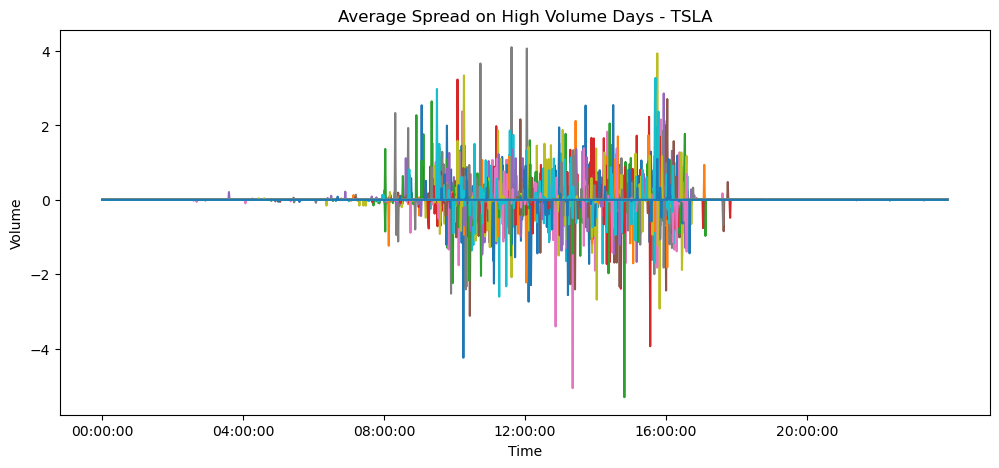

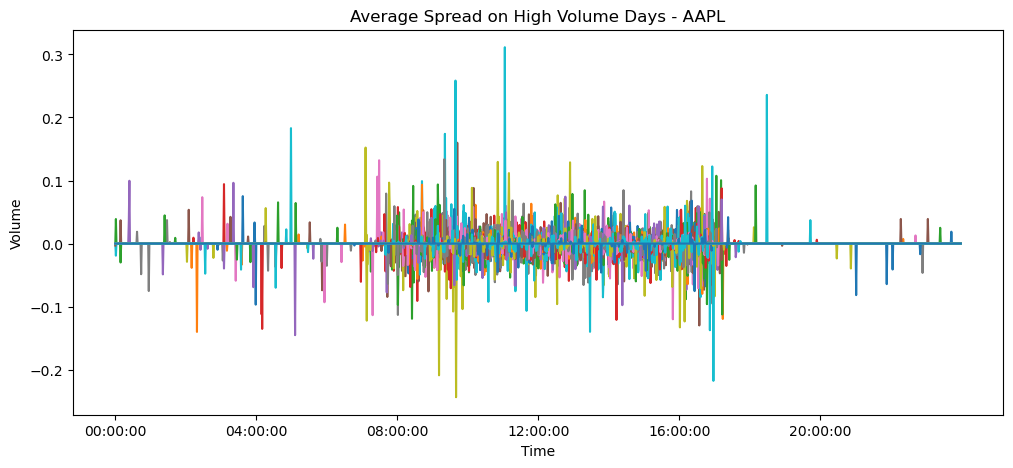

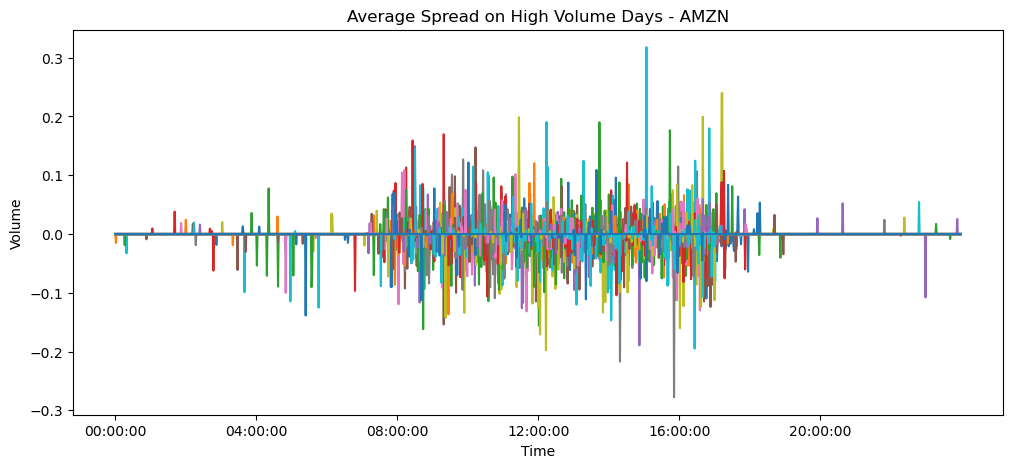

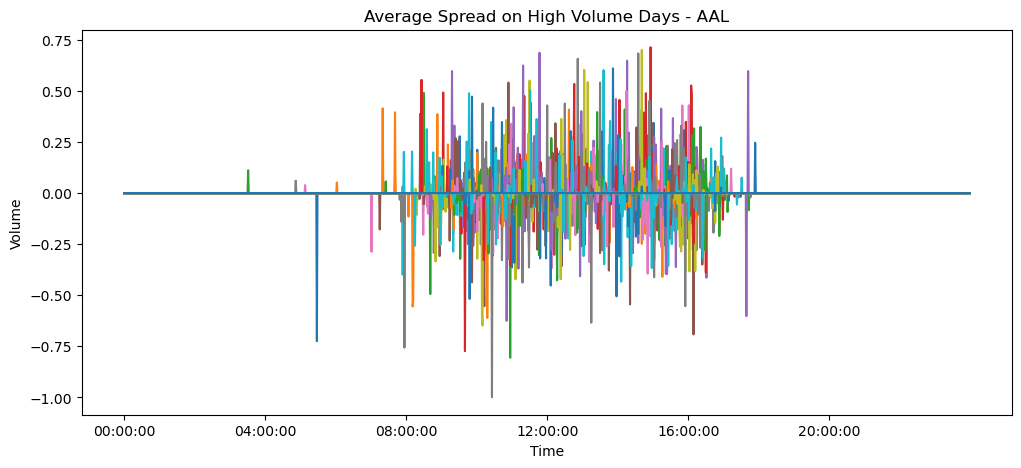

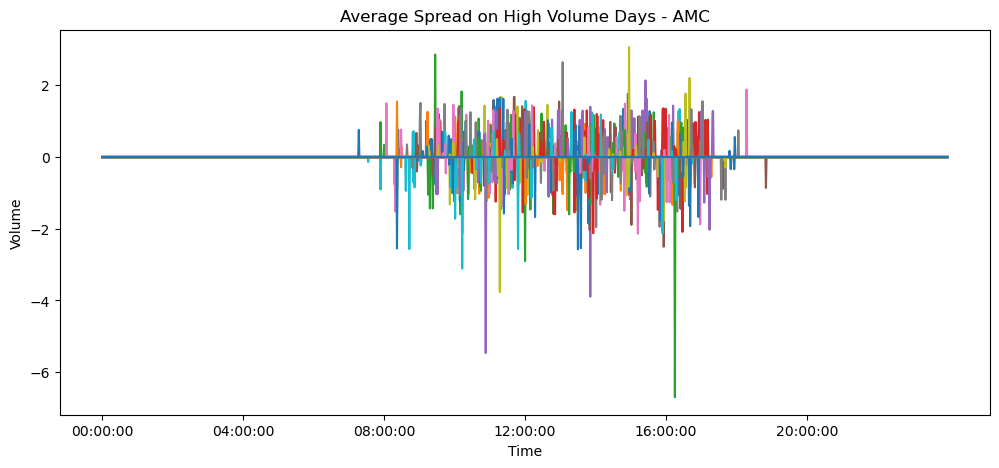

In [389]:
# Intraday analysis - market stress periods -> High Volume Days
all_minutes = pd.date_range(start='00:00:00', end='23:59:00', freq='T').strftime('%H:%M:%S')
for company in bond['company_symbol'].unique():
    plt.figure(figsize=(12, 5))
    high_volume_threshold = bond[bond['company_symbol']==company].groupby(['trd_exctn_dt','trd_exctn_tm'])['ascii_rptd_vol_tx'].sum().reset_index()['ascii_rptd_vol_tx'].quantile(0.75)
    for day in bond[bond['company_symbol']==company]['trd_exctn_dt'].unique():
        data = bond[(bond['company_symbol']==company)&(bond['trd_exctn_dt']==day)].groupby(['trd_exctn_tm']).apply(lambda x: pd.Series([x['ascii_rptd_vol_tx'].sum(),x['spread'].mean()],index=['volume','spread'])).reset_index().sort_values(by='trd_exctn_tm')
        data = data[data['volume'] > high_volume_threshold]
        data = data.set_index('trd_exctn_tm').reindex(all_minutes,fill_value=0).fillna(0).reset_index()
        plt.plot(data['index'], data['spread'], label=day)
    plt.xticks(data['index'][::240].index, data['index'][::240])
    plt.title('Average Spread on High Volume Days - '+company)
    plt.xlabel('Time')
    plt.ylabel('Volume')

* We can see that during market stress periods which is high volume periods, the interday spread is smaller. 

<Figure size 1200x500 with 0 Axes>

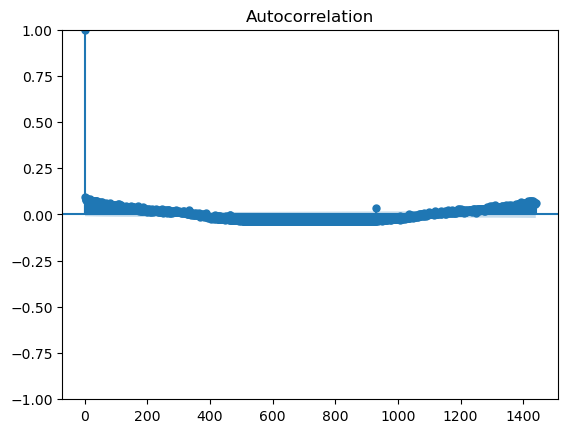

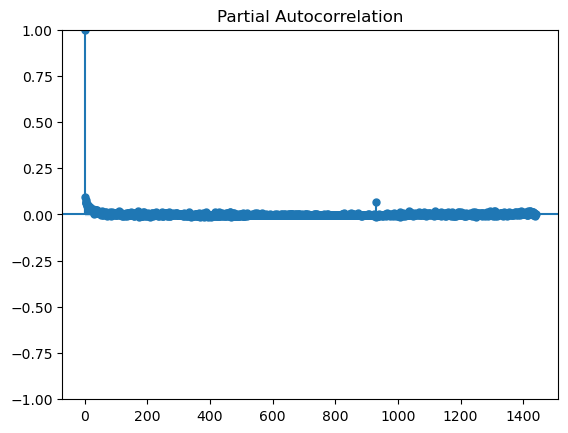

          lb_stat  lb_pvalue
1440  73003.54048        0.0
mean squared error：17648875550.453705


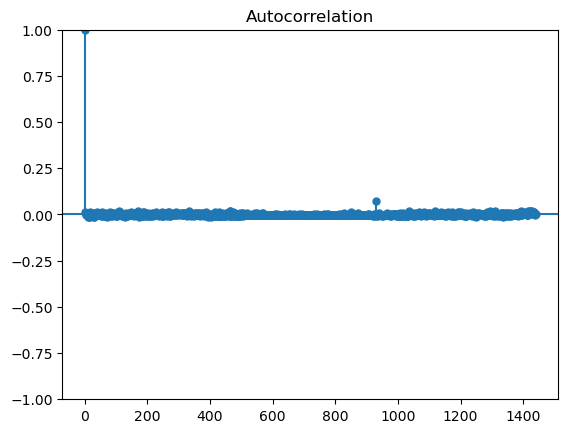

<Figure size 1200x500 with 0 Axes>

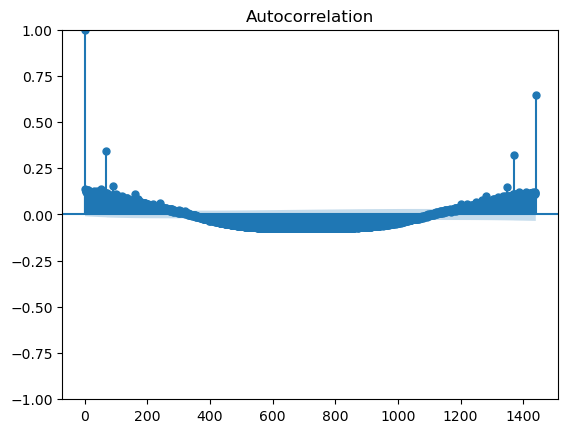

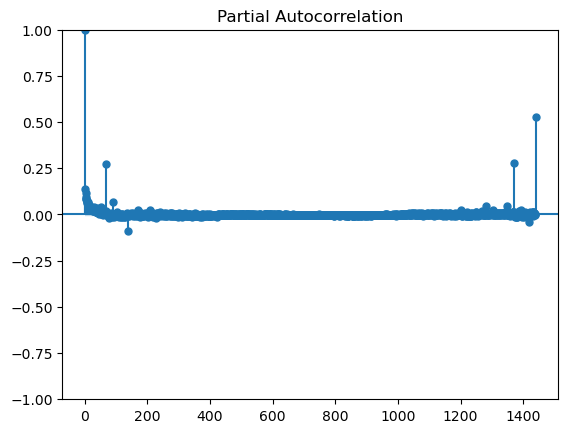

            lb_stat  lb_pvalue
1440  313185.474831        0.0
mean squared error：14022075435339.482


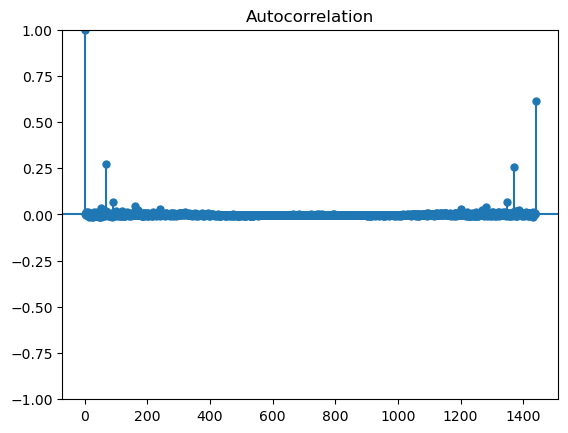

<Figure size 1200x500 with 0 Axes>

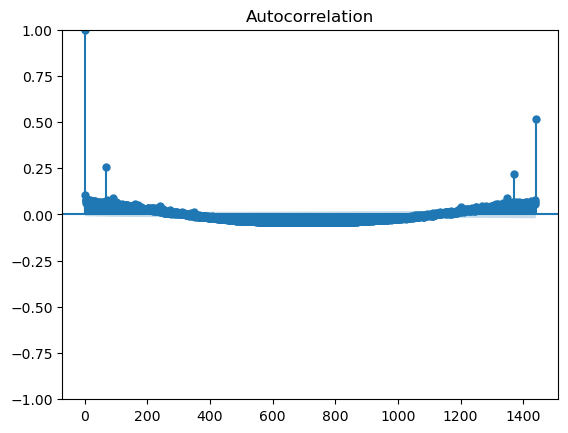

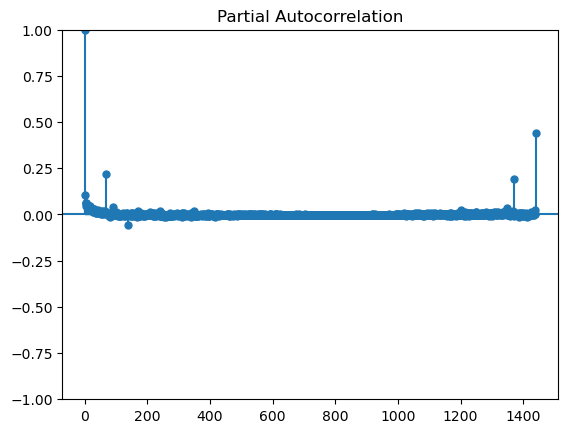

            lb_stat  lb_pvalue
1440  103292.612008        0.0
mean squared error：3955606643286.6797


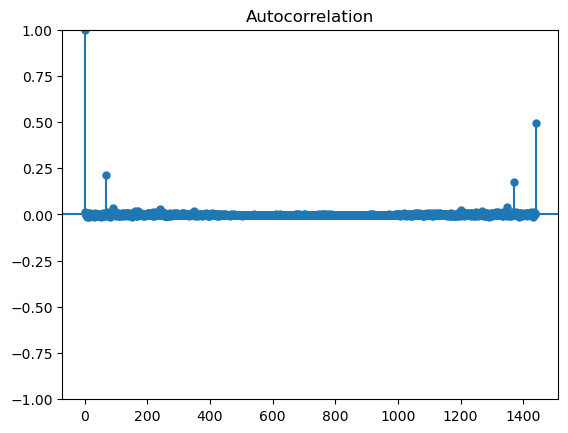

<Figure size 1200x500 with 0 Axes>

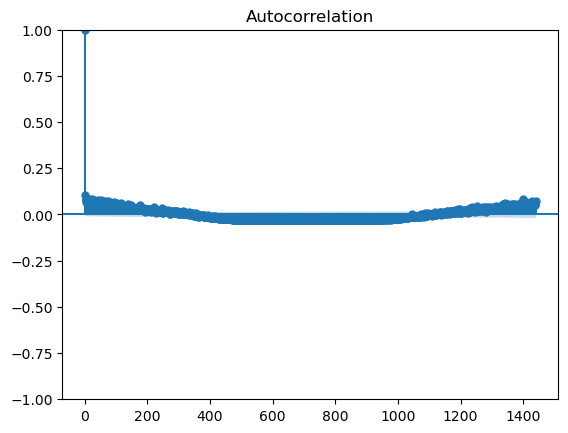

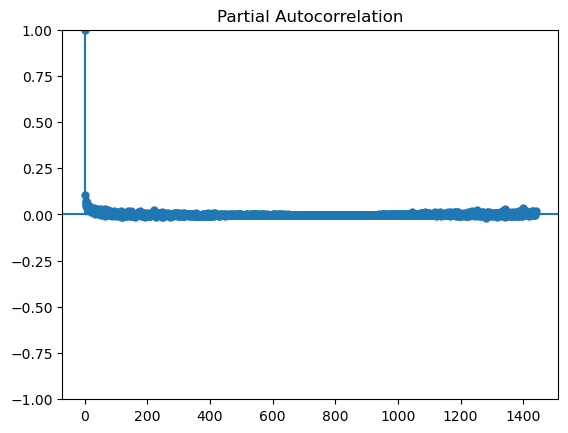

           lb_stat  lb_pvalue
1440  68945.507438        0.0
mean squared error：16853808637.019024


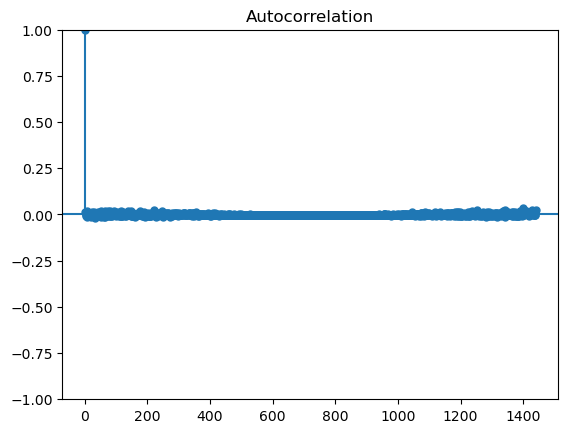

<Figure size 1200x500 with 0 Axes>

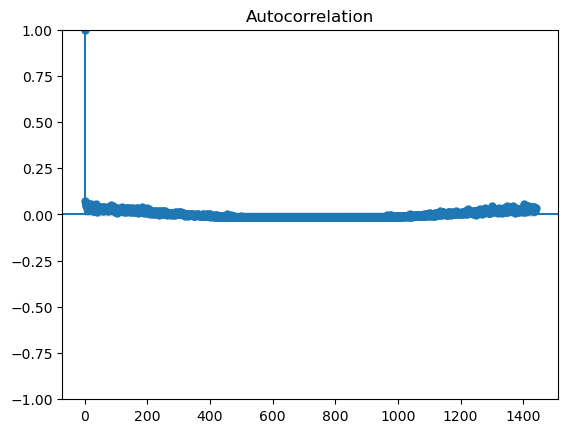

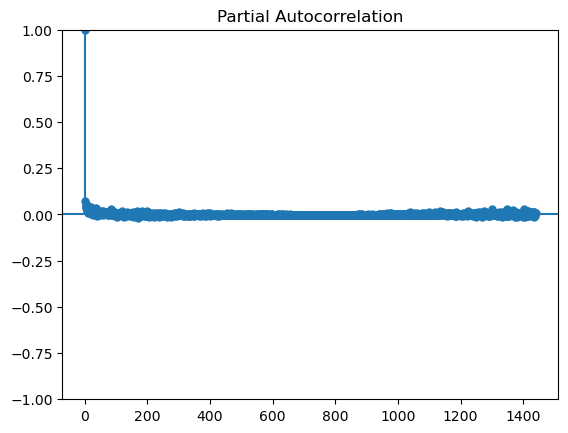

           lb_stat  lb_pvalue
1440  20985.917561        0.0
mean squared error：1840438936.5490723


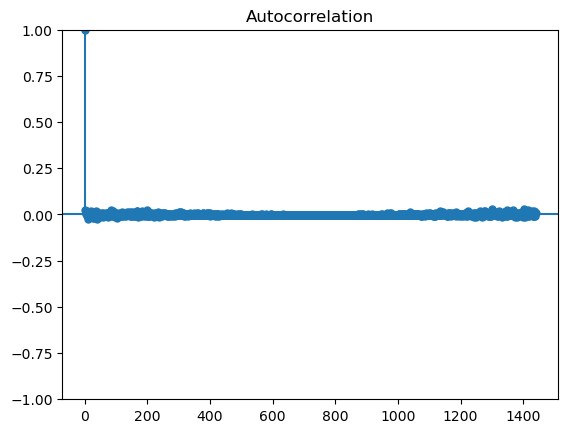

In [446]:
# Intraday analysis - Predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
all_minutes = pd.date_range(start='00:00:00', end='23:59:00', freq='T').strftime('%H:%M:%S')
for company in bond['company_symbol'].unique():
    plt.figure(figsize=(12, 5))
    data = bond[bond['company_symbol']==company].groupby(['trd_exctn_dt','trd_exctn_tm'])['ascii_rptd_vol_tx'].sum().reset_index().sort_values(by=['trd_exctn_dt','trd_exctn_tm'])
    data = pd.concat([data_i.set_index('trd_exctn_tm').reindex(all_minutes,fill_value=0).fillna(0).reset_index() for day,data_i in data.groupby('trd_exctn_dt')]).reset_index(drop=True)
    plot_acf(data['ascii_rptd_vol_tx'], lags=1440)  
    plot_pacf(data['ascii_rptd_vol_tx'], lags=1440)
    plt.show()
    ljung_box_results = acorr_ljungbox(data['ascii_rptd_vol_tx'], lags=[1440], return_df=True)
    print(ljung_box_results)
    train = data['ascii_rptd_vol_tx'][:len(data)-1440]
    test = data['ascii_rptd_vol_tx'][-1440:]
    model = ARIMA(data['ascii_rptd_vol_tx'], order=(4, 0, 4)).fit()
    predictions = model.forecast(steps=1440)
    mse = mean_squared_error(test, predictions)
    print(f'mean squared error：{mse}')
    residuals = model.resid
    plot_acf(residuals, lags=1440)
    plt.show()

* From the ACF plot:
    * The autocorrelation coefficients gradually decline with increasing lags and spike at certain points, which may indicate periodic behavior in the data.
* From the PACF plot:
    * The PACF drops quickly to near-zero values after a few initial lags and mostly remains within the confidence intervals across the range of lags, typically suggesting a possible order for an AR model.
* Ljung-Box test results:
    * The statistic is very high, and the p-value is near 0, which typically indicates the presence of autocorrelation, suggesting that the series may not be purely random.